<a href="https://colab.research.google.com/github/ahmadryan/MLTSA_RQudsi/blob/master/HW4_RQudsi/MCMCOutliers_Probability_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
from scipy.optimize import curve_fit
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install emcee
!pip install corner

     |████████████████████████████████| 51kB 2.2MB/s 
  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11642 sha256=62458f0dfc662bd64261cef348b290c213ec3ceec743e6745a136a6efd32a871
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


In [0]:
import emcee
import corner
import scipy.optimize as op
from corner import hist2d

In [0]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def line(x, slope, intercept):
    """ creates a line 
    x: exogenous variable
    slope: slope line parameter
    intercept: intercept line parameter
    """
    return x * slope + intercept


Run the cells of code below until you reach the assignment cell. This will read in data and run simpler models that you can look at to help yourself creating the one in the assignment

# read in data

In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW4/table1.dat",
                   sep=" ")
data.head()

,x,y,sy,sx,rxy
0,201,592,61,9,-0.84
1,244,401,25,4,0.31
2,47,583,38,11,0.64
3,287,402,15,7,-0.27
4,203,495,21,5,-0.33


In [0]:
nall = len(data)
n = nall - 5

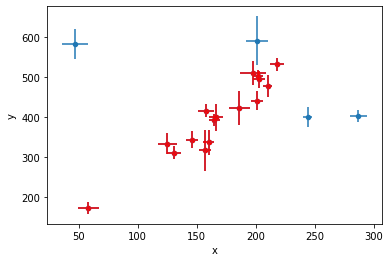

In [7]:
ax = data.plot(x='x', y="y", yerr="sy", xerr="sx", kind="scatter");
data[4:].plot(x='x', y="y", yerr="sy", xerr="sx", kind="scatter", ax=ax, color='r');

Fig 1: All data from https://arxiv.org/pdf/1008.4686.pdf: data in red is the code dataset, data in blue are presumed outliers

# get the initial guess by somple polynomial fitting to the restricted dataset

In [12]:
rdata = data[4:]
pars = np.polyfit(rdata.x, rdata.y, 1)
pars

array([ 2.21665602, 28.84345193])

## MCMC

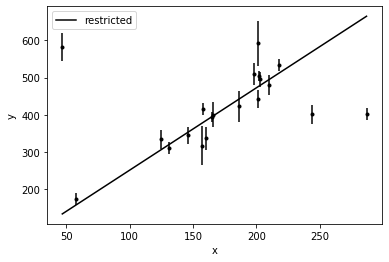

In [13]:
xx = np.arange(data.x.min(), data.x.max(), 0.1)
pl.errorbar(data.x, data.y, data.sy, fmt='.',  color='k')
pl.plot(xx, line(xx, pars[0], pars[1]), 'k-', label="restricted")
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

Fig 2: the polynomial best fit obtained with numpy.polyfit() overplotted to the dataset in Figure 1.

In [0]:
#define a log likelihood that includes 
# - parameters slope and intercept (m, b), 
# - the probability that the point is an outlier Pb 
# - and a distribution to the outliers, parameters (Yb, Vb), the mean and variance of the distribution of outliers

def lnlike(theta, x, y, yerr):
    '''log likelihood
    theta: 5 parameters vector, see prior for details,
    x: exogenous vextor
    y: endoogenous vector
    yerr: uncertainties vector
    '''
    
    m, b = theta
    #line fit model
    model = m * x + b
    #variance of data
    sig2 = yerr**2
    
    #normalization: this is importnat because we have 2 linearly combined pieces of model
    den = 2 * np.pi * sig2
    
    #this is the probability that the point comes from the line
    a = (1/ np.sqrt(den)) * exp(-(y-model)**2 / (2.0 * sig2) )
    
    return  np.sum(np.log(a))

In [0]:
def lnprior(theta):
    '''
    logprior on the parameters theta
    theta: 5 parameter vector: slpoe, intercept, 
                                Yb mean of the process that creates the outliers,
                                Pb probability that a point is an outlier,
                                V the variance of the process that generates outliers
    '''
    m, b = theta
    if -200 < b < 500 and 0 < m < 10.0 :
        #Pb is a probability so it is bound to 0-1
        return 0.0
    
    return -np.inf

def lnprob(theta, x, y, yerr):
    ''' log likelihood * log prior: the posterior
    '''
    lp = lnprior(theta)
    
    if not np.isfinite(lp) :
        return -np.inf

    lnl = lnlike(theta, x, y, yerr)

    if  np.isnan(lnl):
        return -np.inf

    return lp + lnl

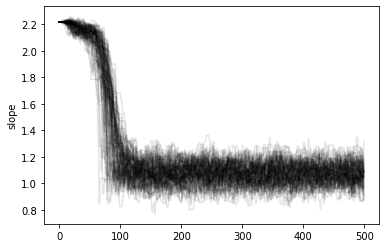

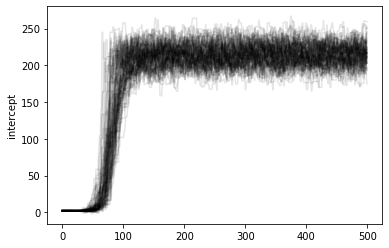

In [18]:
ndim, nwalkers = 2, 100 # number of variables optimized over, number of walkers per variable
init = np.hstack([pars[0], pars[0]]) # initialize the variable at a single point with some noise
pos = [init + 
       init * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] #  
sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                lnprob, 
                                args=(data.x, data.y,
                                     data.sy))
sampler.run_mcmc(pos, 500);
labels = ["slope", "intercept","Yb mean of the process that creates the outliers",
               "Pb probability that a point is an outlier",
                 "V" ]

for i in range(ndim):
    pl.figure()
    for j in range(100): 
        pl.plot(sampler.chain[j,:,i], 'k', alpha=0.1)
    pl.ylabel(labels[i])
        
        
burnout = 150
samples = sampler.chain[:, burnout:, :].reshape((-1, ndim))

In [0]:
pos

Fig 3: The walkers chains obtained from the ```ecmee``` implementation of the affine invariant algorithm https://emcee.readthedocs.io/en/stable/

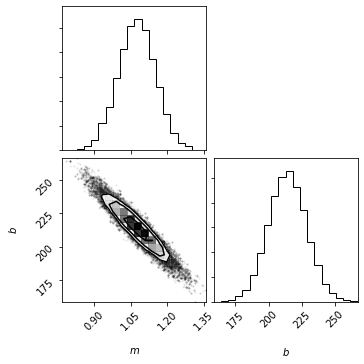

In [38]:
fig = corner.corner(samples, 
                        labels=["$m$", "$b$", "Y", r"$P_b$", "V"],
                        truths=init)

m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples[:,:2], [16, 50, 84],
                                                axis=0)))

# Fig 4: Caption: discuss this plot

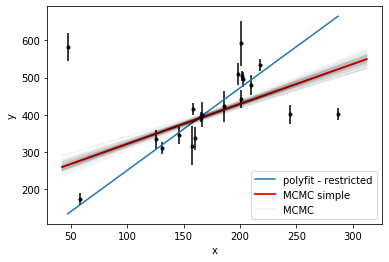

In [44]:
xl = np.arange(data.x.min() * 0.9, data.x.max() * 1.1, 10)
pl.errorbar(data.x, data.y, yerr=data.sy, fmt=".k")
pl.plot(xx, line(xx, pars[0], pars[1]), '-', label="polyfit - restricted")
pl.plot(xl, line(xl, m_mcmc[0], b_mcmc[0]), color="r", lw=2, 
        alpha=0.9, label="MCMC simple")
for m, b in samples[np.random.randint(len(samples), size=100)][:,:2]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.02)
pl.plot(xl, m*xl+b, color="k", alpha=0.05, label="MCMC")
pl.legend();
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

Fig 5: Same as Figure 2 with the results of the MCMC best fit to the sample likelihood equation derived from tha assumption of a line generative process with Gaussian uncertainties. In red is the median value of the parameters slope and intercept optained with a 100 walkers over a 500 steps chain (removing a 150 points burn-in region) and in gray are random samples from the parameter distributions. 

The line fit diverges significantly from the original polynomial fit due to the inclusion of outlier points in the dataset. 

In [0]:
#define a log likelihood that includes 
# - parameters slope and intercept (m, b), 
# - the probability that the point is an outlier Pb 
# - and a distribution fo the outliers, parameters (Yb, Vb), the mean and variance of the distribution of outliers

def lnlike(theta, x, y, yerr):
    '''log likelihood
    theta: 5 parameters vector, see prior for details,
    x: exogenous vextor
    y: endoogenous vector
    yerr: uncertainties vector
    '''
    
    m, b, Yb, Pb, V = theta
    #line fit model
    model = m * x + b
    #variance of data
    sig2 = yerr**2
    
    #normalization: this is importnat because we have 2 linearly combined pieces of model
    den = 2 * np.pi * sig2
    
    #this is the probability that the point comes from the line
    linelik = (1 - Pb) / np.sqrt(den) * exp(-(y-model)**2 /  2.0 / sig2)

    #this is the probability that it does not
    gausslik = Pb / np.sqrt(den + 2*np.pi*V) *\
    exp (-(y - Yb)**2 / 2 / (V + sig2))
    
    return  np.sum(np.log(linelik + gausslik))

In [0]:
def lnprior(theta):
    '''
    logprior on the parameters theta
    theta: 5 parameter vector: slpoe, intercept, 
                                Yb mean of the process that creates the outliers,
                                Pb probability that a point is an outlier,
                                V the variance of the process that generates outliers
    '''
    m, b, Yb, Pb, V = theta
    if -200 < b < 500 and 0 < m < 10.0 :
        #Pb is a probability so it is bound to 0-1
        if Pb < 0 or Pb > 1:
            return -np.inf
        # set some constraints on the mean of the process that creates the outliers
        if  Yb > ymean + 150 or Yb < ymean - 150:
            return -np.inf

        if V < 0:
            return -np.inf
        #print("3")
        return 0.0
    
    return -np.inf

def lnprob(theta, x, y, yerr):
    ''' log likelihood * log prior: the posterior
    '''
    lp = lnprior(theta)

    if not np.isfinite(lp) :
        return -np.inf

    lnl = lnlike(theta, x, y, yerr)

    if  np.isnan(lnl):
        return -np.inf

    return lp + lnl

In [0]:
ymean = data.y.mean()
#initialize from the restricted problem LA solution 


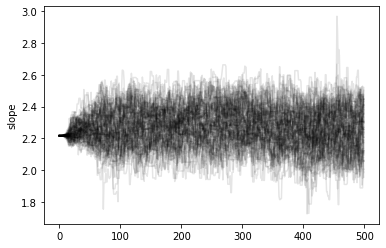

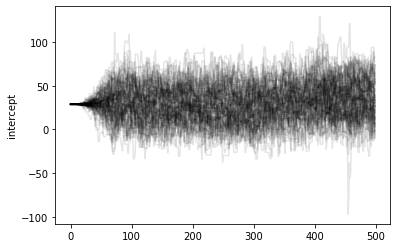

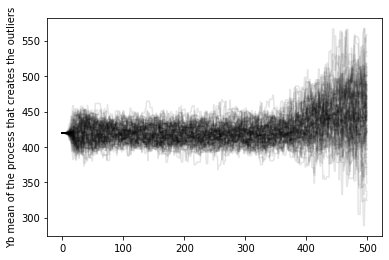

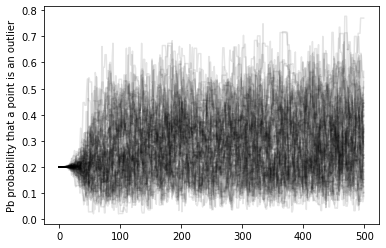

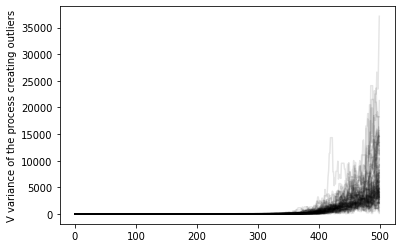

In [50]:
ndim, nwalkers = 5, 100 # number of variables optimized over, number of walkers per variable
init = np.hstack([pars[0], pars[1], ymean, 
                  0.2, 0.1]) # initialize the variable at a single point with some noise
pos = [init + 
       init * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] #  
sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                lnprob, 
                                args=(data.x, data.y,
                                     data.sy))
sampler.run_mcmc(pos, 500);
labels = ["slope", "intercept","Yb mean of the process that creates the outliers",
               "Pb probability that a point is an outlier",
                 "V variance of the process creating outliers" ]
for i in range(ndim):
    pl.figure()
    for j in range(100): 
        pl.plot(sampler.chain[j,:,i], 'k', alpha=0.1)
    pl.ylabel(labels[i])
        
        
burnout = 150
samples = sampler.chain[:, burnout:, :].reshape((-1, ndim))

Fig 6: same as figure 3 for the parameters of a model tha includes the probability of a Gaussian generative porcess contaminating the dataset generated by a line-generating process (with added Gaussian noise). The added parameters, added to slope and intercept, are the mean and variance of the Gaussian generative process, and the probability that a point is generated by the extraneous provess (not the line) this model is obtained by marginalizing over all datapoints in the set a complete model that includes the individual probability of being generated by the extraneous process for each datapoint. 

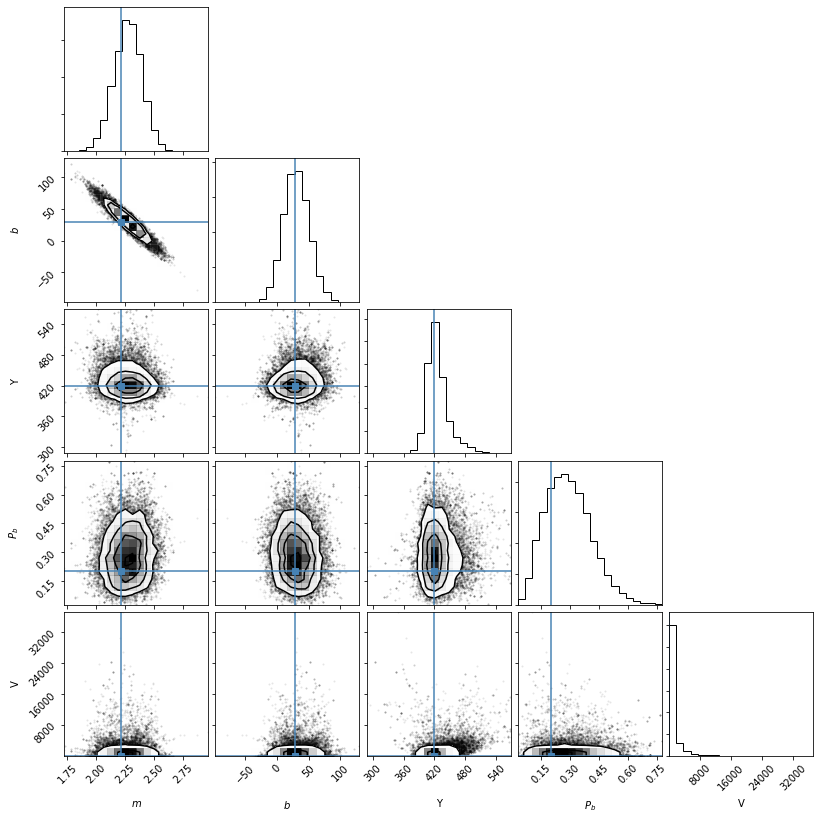

In [51]:
fig = corner.corner(samples, 
                        labels=["$m$", "$b$", "Y", r"$P_b$", "V"],
                        truths=init)
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples[:,:2], [16, 50, 84],
                                                axis=0)))

# Fig 7 : Caption describe this figure. Which parameters del are covariant? Do the parameters span the likelihood effectively? Any suspicious distribution shapes? 

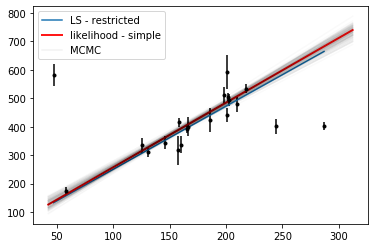

In [52]:
xl = np.arange(data.x.min() * 0.9, data.x.max() * 1.1, 10)
pl.errorbar(data.x, data.y, yerr=data.sy, fmt=".k")
pl.plot(xx, line(xx, pars[0], pars[1]), '-', label="LS - restricted")
pl.plot(xl, line(xl, m_mcmc[0], b_mcmc[0]), color="r", lw=2, alpha=0.9, label="likelihood - simple")
for m, b in samples[np.random.randint(len(samples), size=100)][:,:2]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.02)
pl.plot(xl, m*xl+b, color="k", alpha=0.05, label="MCMC")
pl.legend();

# Fog 8: Caption - describe this figure: why is it a better fit than figure 5? 

# Homework:
##  Fit all Ps

Follow equation 13 in Paragraph 3 of https://arxiv.org/pdf/1008.4686.pdf and code it in the ```emcee``` framework. Obtain the probability that a point comes from the line-generating process, or a separate "Gaussian generative" process. 

Print the mean and standard deviations of the Gaussian generative process and their uncertainties. 

Plot all the walker chains (same as Fig 3 and 6 for this model)

Plot the marginalized parameter distributions (same as Fig 4 & 7 for this model)

Plot the data points, the best fit line and the lines generated by the MCMC ensambles (as I did in the previous figure) and print a label next to each point that shows the point index (the index of the row corresponding to that point in the source dataframe) and the probability that it is from the Gaussian generative process. Write in red the label if the probability of being an outlier is > 50%


In [63]:
x = data.x
y = data.y
yerr = data.sy
len(x)

20

In [68]:
def lnlikeP(theta, P, x, y, yerr):
    '''log likelihood
    theta: 4 parameters vector, see prior for details,
    x: exogenous vextor
    y: endoogenous vector
    yerr: uncertainties vector
    P: probability that a point is an outlier, a x-long vector
    '''

    m, b, Yb, V = theta

    #line fit model
    model = m * x + b

    #Variance of the data
    sig2 = yerr**2

    #normalization: this is importnat because we have 2 linearly combined pieces of model
    den = 2 * np.pi * sig2

    #q = zeros_like(x)
    #q[4:] = 1

    #this is the probability that the point comes from the line
    linelik = (1 / np.sqrt(den) *\
        exp(-(y-model)**2 /  2.0 / sig2))**(1-P)

    #this is the probability that it does not
    gausslik = (1 / np.sqrt(den + 2*np.pi*V) *\
        exp (-(y - Yb)**2 / 2 / (V + sig2)))**(P)

    return  np.sum(np.log(linelik + gausslik))

print("test lnlikP:", lnlikeP((pars[0], pars[1], 400, 300), np.random.rand(len(x)), 
        x, y, yerr))

test lnlikP: -28.36116041368383


In [0]:
def lnpriorP(theta, P):
    '''
    logprior on the parameters theta
    theta: 4 parameter vector: slpoe, intercept, 
                                Yb mean of the process that creates the outliers,
                                V variance of probability that a point is an outlier,
    P: probability that a point is an outlier, a x-long vector
    '''
    m, b, Yb, V = theta
    if -200 < b < 500 and 0 < m < 10.0 :
        #Pb is a probability so it is bound to 0-1
        if Pb < 0 or Pb > 1:
            return -np.inf

        # set some constraints on the mean of the process that creates the outliers
        if  Yb > ymean + 150 or Yb < ymean - 150:
            return -np.inf

        if V < 0:
            return -np.inf
        #print("3")
        return 0.0

    return -np.inf

def lnprobP(theta, x, y, yerr):
    '''
    posterior
    theta: the parameters vector. see lnpriorP
    x: exogenous variable
    y: endogenous variable
    yerr: endogenous uncertainties
    '''

    lp = lnprior(theta)
    
    if not np.isfinite(lp) :
        return -np.inf

    lnl = lnlike(theta, x, y, yerr)

    if  np.isnan(lnl):
        return -np.inf

    return lp + lnl 

In [80]:
probsinit = zeros_like(x)
probsinit[:4] = 1

ndim, nwalkers = 4, 100 # number of variables optimized over, number of walkers per variable
init = np.hstack([pars[0], pars[1], ymean, 0.1]) # initialize the variable at a single point with some noise

pos = [init + init * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                lnprobP, 
                                args=(data.x, data.y,
                                     data.sy))
sampler.run_mcmc(pos, 500);

labels = ["slope", "intercept","Yb mean of the process that creates the outliers",
                 "V variance of the process creating outliers" ]
for i in range(ndim):
    pl.figure()
    for j in range(100): 
        pl.plot(sampler.chain[j,:,i], 'k', alpha=0.1)
    pl.ylabel(labels[i])
        
        
burnout = 150

# note: you can use multiprocessing to speed up the performance
from multiprocessing import Pool
        
samples = sampler.chain[:, burnout:, :].reshape((-1, ndim))

emcee: Exception while calling your likelihood function:
  params: [2.21671163e+00 2.88459273e+01 4.19387437e+02 9.99976820e-02]
  args: (0     201
1     244
2      47
3     287
4     203
5      58
6     210
7     202
8     198
9     158
10    165
11    201
12    157
13    131
14    166
15    160
16    186
17    125
18    218
19    146
Name: x, dtype: int64, 0     592
1     401
2     583
3     402
4     495
5     173
6     479
7     504
8     510
9     416
10    393
11    442
12    317
13    311
14    400
15    337
16    423
17    334
18    533
19    344
Name: y, dtype: int64, 0     61
1     25
2     38
3     15
4     21
5     15
6     27
7     14
8     30
9     16
10    14
11    25
12    52
13    16
14    34
15    31
16    42
17    26
18    16
19    22
Name: sy, dtype: int64, array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-79-b834a4d11e61>", line 35, in lnprobP
    lp = lnprior(theta, P)
TypeError: lnprior() takes 1 positional argument but 2 were given


TypeError: ignored

In [0]:
m_mcmc, b_mcmc = 

In [0]:
samples[:,4:].shape

(15000, 20)

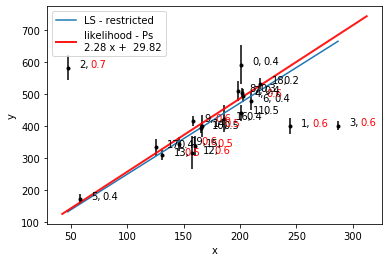

Fig 10: Caption